### SETUP PACKAGES AND READ IN IMAGES

In [2]:
#import needed libraries
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os
import cv2
import imghdr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import layers


C:\Users\eebla\AppData\Local\Temp\ipykernel_36408\1819497594.py:9: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [3]:
#getting rid of images that are not the correct extension or are corrupt.
# also manually got rid of small images <10KB
data_dir = (r'C:\Users\eebla\OneDrive\Documents\side_project')
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)): #it is looping through each of the folders and then all the images in each
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))


### LOAD IN IMAGES WITH TENSORFLOW

In [5]:
#I dont have an NVIDIA graphis card:(
# fun fact if a filename is in chinese it breaks it
#defualt size is 256,256 and 32 per batch, shuffle is true going to need to get them to 224x224 for transfer learning model
#tf.keras.utils.image_dataset_from_directory??

#set wanted image size
IMAGE_SIZE=[224,224]
#set up the directory, tf likes to have subfolders with labels
data_dir = (r'C:\Users\eebla\OneDrive\Documents\side_project')
data= tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(IMAGE_SIZE))


Found 552 files belonging to 2 classes.


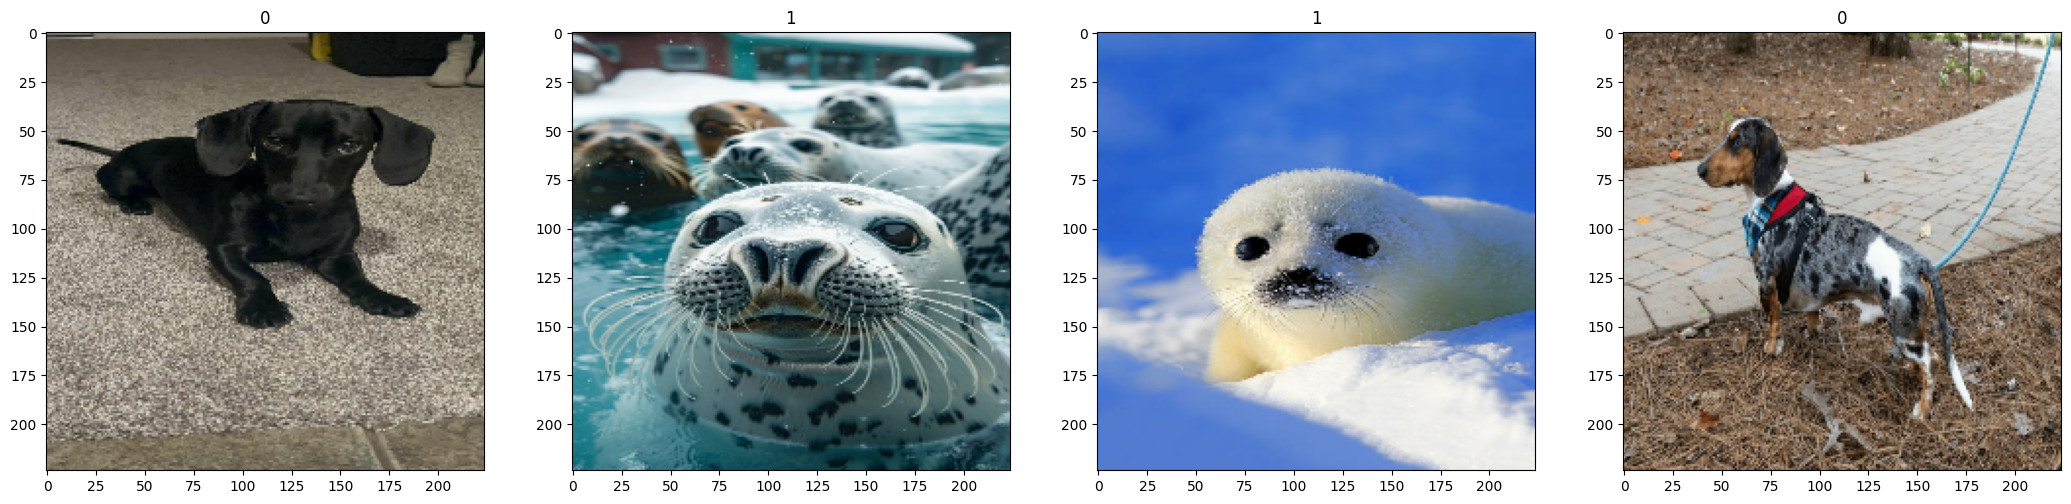

In [6]:
#iterate through images and look at some of them 
#dachshunds are labeled as 1 and chihuahuas are labled as 0
# can run this a bunch and see different batches of 32
data_iterator = data.as_numpy_iterator() #images represented by numpy arrays, grabs batches of 32
batch = data_iterator.next()
batch[0] #this is the arrays reprensting the image
batch[1] #this array represents the labels aka dachshund or seal

fig, ax = plt.subplots(ncols=4, figsize=(26,26))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### PREPROCESS
#### Need to scale data and then split into train, validation and test

Min: 0.0
Max: 1.0


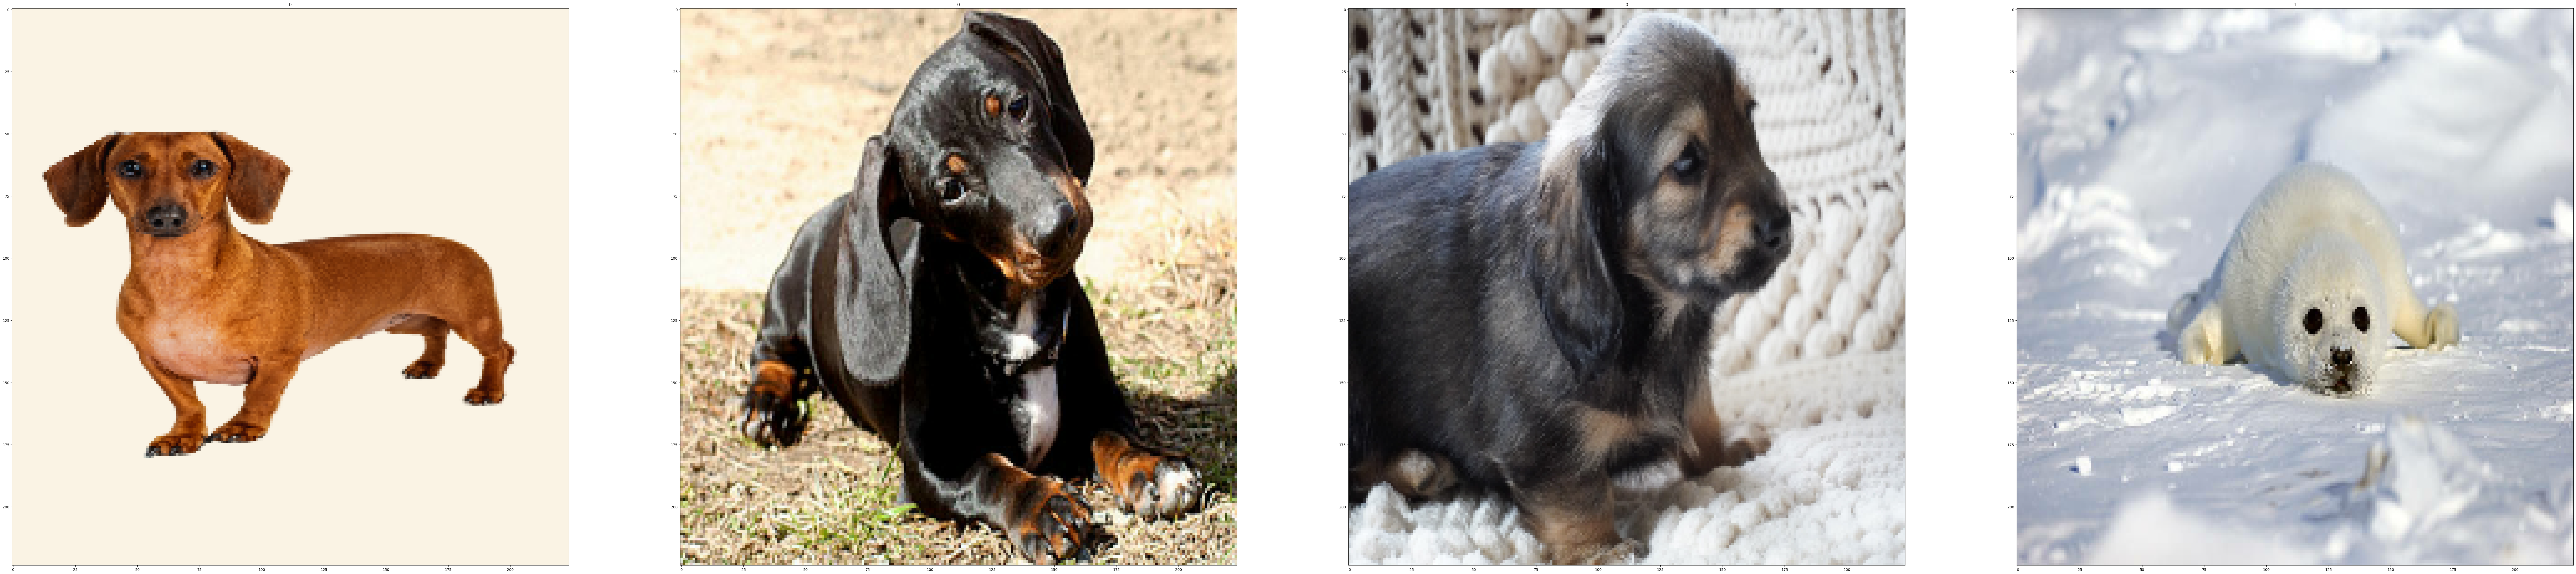

In [8]:
# SCALE- need to scale the arrays from 0 to 1 instead of 0 to 255 (the color scale goes to 255), its in RGB with tensorflow, its BGR with open_cv.
#tensorflow data api -> can see what other functions you can do in the pipeline

#Need to apply this to the pipeline instead of doing it after batch comes in
#x is the images and y is the labels
data=data.map(lambda x,y:(x/255,y)) #the map function is from tf
batch=data.as_numpy_iterator().next()

#checking, looks good this will work. 
print(f'Min: {batch[0].min()}')
print(f'Max: {batch[0].max()}')

#they are all black
fig, ax = plt.subplots(ncols=4, figsize=(128,128))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img) #take out as type is int because they would all be 0 since we scaled it
    ax[idx].title.set_text(batch[1][idx])


### SPLIT INTO TRAIN, VALIDATE AND TEST

In [10]:
print(len(data)) #there are 18 batches of 32

train_size = int(len(data)*.7) #12
val_size = int(len(data)*.2) #3
test_size = int(len(data)*.1) #1

print(train_size)
print(val_size)
print(test_size)

#the take is telling how many batches to do, data is shuffled so there are a mix of 0s and 1s in each batch
train = data.take(train_size) 
val = data.skip(train_size).take(val_size)  
test = data.skip(train_size+val_size).take(test_size) 


18
12
3
1


 ### CNN with augmentation and transfer learning

In [12]:
import tf_keras as tfk
input_shape = (None,224, 224, 3)
hub_url = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-224-feature-vector/2"

model = tfk.Sequential([
    tfk.layers.RandomFlip(mode='horizontal'),  #randomly flips horizontal
    tfk.layers.RandomRotation(0.1), #randomly rotates
    tfk.layers.RandomZoom(0.1),
    hub.KerasLayer(hub_url, trainable=False),  # Can be True, see below.
    tfk.layers.Flatten(),
    tfk.layers.Dense(1, activation='sigmoid') # output layer
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              410208    
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                        

In [13]:
#fitting model on training- validation went down around 10 then went back up
hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10



12/12 [==============================] - 13s 475ms/step - loss: 0.5000 - accuracy: 0.7188 - val_loss: 0.3683 - val_accuracy: 0.7812
Epoch 2/10
12/12 [==============================] - 5s 368ms/step - loss: 0.2490 - accuracy: 0.8880 - val_loss: 0.1448 - val_accuracy: 0.9583
Epoch 3/10
12/12 [==============================] - 5s 406ms/step - loss: 0.1514 - accuracy: 0.9740 - val_loss: 0.1287 - val_accuracy: 0.9792
Epoch 4/10
12/12 [==============================] - 5s 401ms/step - loss: 0.1070 - accuracy: 0.9818 - val_loss: 0.0827 - val_accuracy: 0.9896
Epoch 5/10
12/12 [==============================] - 4s 348ms/step - loss: 0.0904 - accuracy: 0.9870 - val_loss: 0.0702 - val_accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 6s 472ms/step - loss: 0.0792 - accuracy: 0.9870 - val_loss: 0.0524 - val_accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 9s 722ms/step - loss: 0.0544 - accuracy: 0.9948 - val_loss: 0.0342 - val_accuracy: 1.0000
Epoch 8/10
12/12

### PLOT THE PERFORMANCE

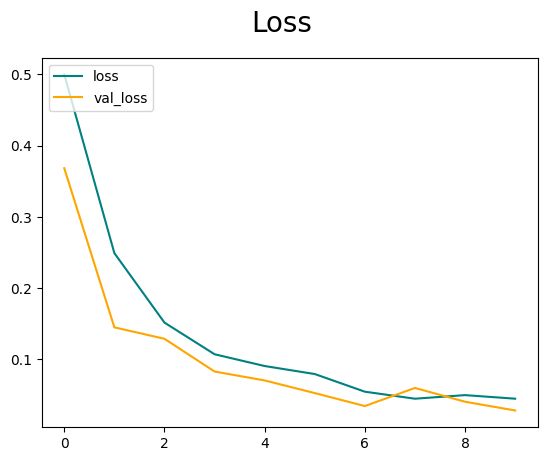

In [15]:
#hist.history can see the accuracy, loss is stored for training and validation
#looks great, both the training and validation loss is decreasing over time
#plot loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss') #traiing loss
plt.plot(hist.history['val_loss'], color='orange', label='val_loss') #validation loss
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

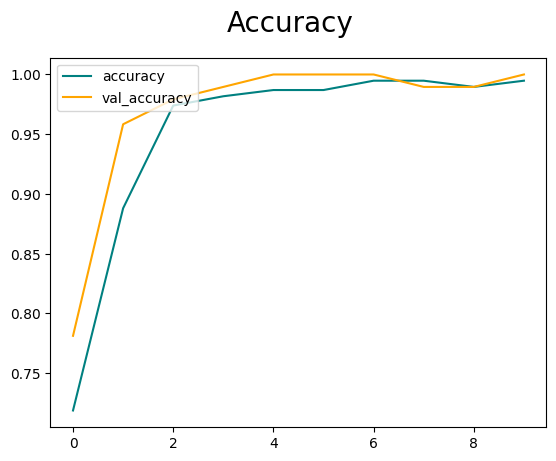

In [16]:
#plot accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy') #training accuracy
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy') #validation accuracy
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### EVALUATION ON TEST SET

In [18]:
loss, acc = model.evaluate(test)
print(f"Test Loss: {loss}, Test Accuracy: {acc}")


1/1 [==============================] - 2s 2s/step - loss: 0.0169 - accuracy: 1.0000
Test Loss: 0.01686013862490654, Test Accuracy: 1.0


### MORE testing

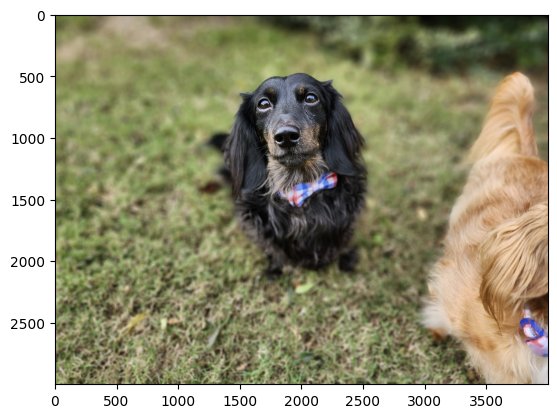

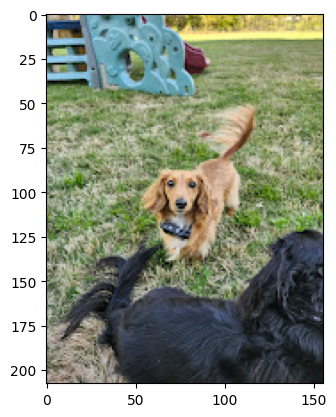

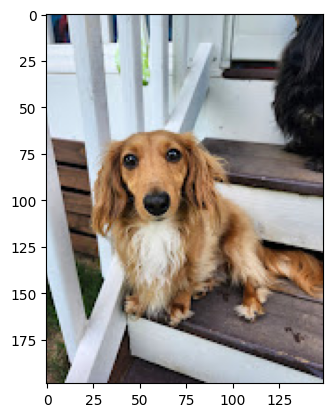

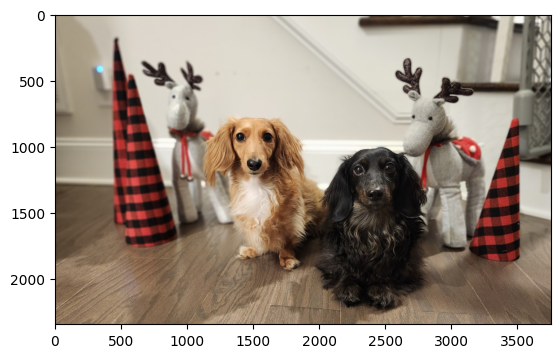

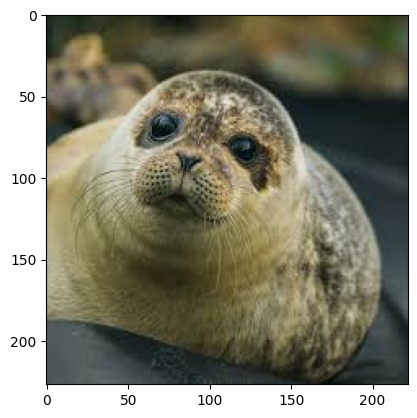

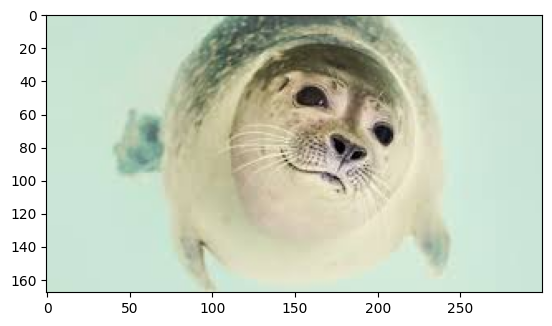

In [20]:
#test on my dachshunds Cannoli and Biscotti and my old boss's chihuahua peachy
#since we are using open cv its showing them in bgr that is why it looks a little off colorwise, fixed it
#Cannoli
img_c = cv2.imread(r'C:\Users\eebla\OneDrive\Documents\cannoli.jpg')
plt.imshow(cv2.cvtColor(img_c,cv2.COLOR_BGR2RGB))
plt.show()

#Biscotti
img_b= cv2.imread(r'C:\Users\eebla\OneDrive\Documents\biscotti.jpg')
plt.imshow(cv2.cvtColor(img_b,cv2.COLOR_BGR2RGB))
plt.show()
#Biscotti 2
img_b2= cv2.imread(r'C:\Users\eebla\OneDrive\Documents\biscotti2.jpg')
plt.imshow(cv2.cvtColor(img_b2,cv2.COLOR_BGR2RGB))
plt.show()

#both my dogs
img_both= cv2.imread(r'C:\Users\eebla\OneDrive\Documents\both.jpg')
plt.imshow(cv2.cvtColor(img_both,cv2.COLOR_BGR2RGB))
plt.show()

#seal teset image
img_p1= cv2.imread(r'C:\Users\eebla\OneDrive\Documents\seal_test.jpg')
plt.imshow(cv2.cvtColor(img_p1,cv2.COLOR_BGR2RGB))
plt.show()

#seal test image
img_p2= cv2.imread(r'C:\Users\eebla\OneDrive\Documents\seal_test_2.jpg')
plt.imshow(cv2.cvtColor(img_p2,cv2.COLOR_BGR2RGB))
plt.show()



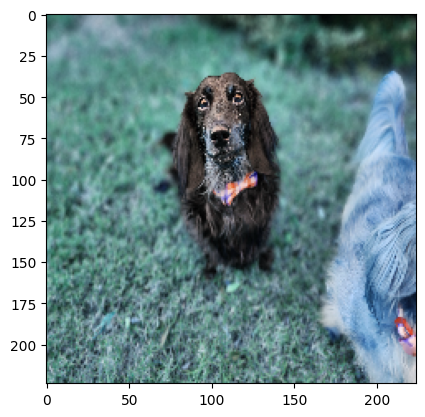

In [21]:
#we need to resize these images before passing through neural network
resize_c = tf.image.resize(img_c, IMAGE_SIZE)
resize_b = tf.image.resize(img_b, IMAGE_SIZE)
resize_b2 = tf.image.resize(img_b2,IMAGE_SIZE)
resize_both = tf.image.resize(img_both, IMAGE_SIZE)
resize_p1 = tf.image.resize(img_p1, IMAGE_SIZE)
resize_p2= tf.image.resize(img_p2, IMAGE_SIZE)

# checking, it works
#plt.imshow(resize_c.numpy().astype(int))
#plt.show()

In [35]:
#scale and predict
yhatc = model.predict(np.expand_dims(resize_c/255, 0)) 
yhatb = model.predict(np.expand_dims(resize_b/255, 0))
yhatb2 = model.predict(np.expand_dims(resize_b2/255, 0))
yhatboth = model.predict(np.expand_dims(resize_both/255, 0))
yhatp1 = model.predict(np.expand_dims(resize_p1/255, 0))
yhatp2 = model.predict(np.expand_dims(resize_p2/255, 0))

#function to print out what the predictions are
def what_dog(pred):
    if pred > 0.5: 
        print(f'Predicted class is a Seal: {pred}')
    else:
        print(f'Predicted class is a Dachshund: {pred}')

#got them all correct
what_dog(yhatc) 
what_dog(yhatb) 
what_dog(yhatb2) 
what_dog(yhatboth) 
what_dog(yhatp1) 
what_dog(yhatp2) 

1/1 [==============================] - 1s 923ms/step
Predicted class is a Dachshund: [[0.00379731]]
Predicted class is a Dachshund: [[0.0075904]]
Predicted class is a Dachshund: [[0.09564621]]
Predicted class is a Dachshund: [[0.16695812]]
Predicted class is a Seal: [[0.9739798]]
Predicted class is a Seal: [[0.93229675]]
